![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [9]:
import pandas as pd

In [20]:
symbol = 'EURUSD'
df = pd.read_csv('data/forex/oanda/second/eurusd/20140506_quote.zip', compression='zip', names=['millisecond', 'open_bid', 'high_bid', 'low_bid', 'close_bid', 'volume_bid', 'open_ask', 'high_ask', 'low_ask', 'close_ask', 'volume_ask'], sep=',', quotechar='"')
del df['volume_bid']
del df['volume_ask']

In [42]:
import datetime

from QuantConnect import Resolution, Market
from QuantConnect.Algorithm import QCAlgorithm
from QuantConnect.Brokerages import BrokerageName
import pandas as pd
from QuantConnect.Orders import OrderType, OrderStatus

from algo import get_values


class WilliamsEMA(QCAlgorithm):
    def Initialize(self):
        self.RISK = 2.
        self.margin = 50.
        self.pct_of_account = 0.8
        # self.max_risk_rate = 0.02
        self.time_limit = 120
        self.max_stop_loss = 0.0020
        self.stoch_rsi_max = 0.8
        self.stoch_rsi_min = 0.2


        self.SetStartDate(2021, 1, 15)  # Set Start Date
        # self.SetEndDate(2020, 1, 10)  # Set End Date
        self.SetCash(1000)  # Set Strategy Cash
        self.SetBrokerageModel(BrokerageName.OandaBrokerage)
        # self.UniverseSettings.Resolution = Resolution.Minute
        self.SetWarmup(200)
        # self.symbol_names = ["USDAUD", "USDCAD", "USDCHF", "USDEUR", "USDGBP",
        #                      "USDHKD", "USDDKK", "USDCZK", "USDZAR",
        #                      "USDSEK", "USDSAR", "USDNOK", "USDMXN"]
        # self.symbol_names = ["AUDCAD", "EURUSD", "USDCAD", "USDCHF", "NZDUSD", "GBPUSD"]
        self.symbol_names = ['EURUSD']

        self.symbols = []
        self.data_second = {}
        self.df = {}
        for symbol in self.symbol_names:
            self.data_second[symbol] = []
#             self.symbols.append(self.AddForex(symbol, Resolution.Second, Market.Oanda, leverage=self.margin,
#                                               fillDataForward=False))
            self.df[symbol] = pd.DataFrame()
            # self.df[symbol].index.name = 'datetime'
        self.order_values = {}
        self.order_types = ['stop', 'price_target']
        self._tickets = {t: {} for t in self.order_types}
        self.last_time = datetime.time(0)

    def OnOrderEvent(self, orderEvent):
        order = self.Transactions.GetOrderById(orderEvent.OrderId)
        s = order.Symbol.Value
        if order.Type == OrderType.Market and order.Status == OrderStatus.Filled:
            quantity = order.Quantity
            if quantity != 0 and len(self.order_values) > 0:
                stop = self.order_values[s]['stop']
                price_target = self.order_values[s]['price_target']
                self.Debug(f"{order.Time}, {stop}, {price_target}, {order.Price}")
                del self.order_values[s]
                if stop == price_target or not min(stop, price_target) < order.Price < max(stop, price_target):
                    self.liquidate_and_cancel_orders()
                else:
                    self._tickets['stop'][s] = self.StopMarketOrder(s, -quantity, stop, "STOP Set")
                    self._tickets['price_target'][s] = self.LimitOrder(s, -quantity, price_target, "Price Target Set")
        elif order.Type == OrderType.Limit and order.Status == OrderStatus.Filled:
            self._tickets['stop'][s].Cancel()

            del self._tickets['stop'][s]
            del self._tickets['price_target'][s]
        elif order.Type == OrderType.StopMarket and order.Status == OrderStatus.Filled:
            self._tickets['price_target'][s].Cancel()

            del self._tickets['stop'][s]
            del self._tickets['price_target'][s]

    def liquidate_and_cancel_orders(self):
        openOrders = self.Transactions.GetOpenOrders()
        if len(openOrders) > 0:
            for x in openOrders:
                self.Transactions.CancelOrder(x.Id)
        self._tickets = {t: {} for t in self.order_types}
        self.order_values = {}
        self.Liquidate()

    def OnData(self, data):
        """OnData event is the primary entry point for your algorithm. Each new data point will be pumped in here.
            Arguments:
                data: Slice object keyed by symbol containing the stock data
        """
        for symbol in data.keys():
            if symbol not in data.QuoteBars:
                continue
            quoteBarsBid = data.QuoteBars[symbol].Bid
            quoteBarsAsk = data.QuoteBars[symbol].Ask
            self.data_second[symbol.Value].append({
                'close_bid': quoteBarsBid.Close, 'open_bid': quoteBarsBid.Close,
                'high_bid': quoteBarsBid.Close, 'low_bid': quoteBarsBid.Close,
                'close_ask': quoteBarsAsk.Close, 'open_ask': quoteBarsAsk.Close,
                'high_ask': quoteBarsAsk.Close, 'low_ask': quoteBarsAsk.Close
            })

        time = self.UtcTime.replace(tzinfo=None, microsecond=0)
        if time.second != 0 and self.last_time.second < time.second:
            self.last_time = time
            return
        self.last_time = time

        new_row = {}
        # date = pd.Timestamp(data[list(data.keys())[0]].EndTime, tzinfo=datetime.timezone.utc)
        date = time
        for symbol, data_s in self.data_second.items():
            if len(data_s) == 0:
                self.Debug('skip')
                continue
            data_s = pd.DataFrame(data_s)
            new_row[symbol] = pd.Series({
                'close_bid': data_s['close_bid'].iloc[-1], 'open_bid': data_s['open_bid'].iloc[0],
                'high_bid': data_s['high_bid'].max(), 'low_bid': data_s['low_bid'].min(),
                'close_ask': data_s['close_ask'].iloc[-1], 'open_ask': data_s['open_ask'].iloc[0],
                'high_ask': data_s['high_ask'].max(), 'low_ask': data_s['low_ask'].min(),
            })
            new_df = pd.DataFrame(new_row[symbol]).transpose()
            new_df.index = [date]
            self.df[symbol] = pd.concat([self.df[symbol], new_df]).iloc[-200:]
            self.data_second[symbol] = []

        if not (datetime.time(12) < time.time() < datetime.time(20)):
            if self.Portfolio.Invested:
                self.liquidate_and_cancel_orders()
            return

        # time limit
        if 'stop' in self._tickets and len(self._tickets['stop']) > 0:
            symbols = list(self._tickets['stop'].keys())
            for s in symbols:
                time_diff = (time - self._tickets['stop'][s].Time.replace(tzinfo=None)).seconds / 60
                if self._tickets['stop'][s].Status != OrderStatus.Filled and time_diff > self.time_limit:
                    self.Debug(f"CANCEL --- {s}, {time_diff}")
                    self.liquidate_and_cancel_orders()

        if not self.IsWarmingUp and not self.Portfolio.Invested:
            self.ProfitTargets = {}
            self.StopTargets = {}
            for symbol in data.keys():
                if self.df[symbol.Value].shape[0] < 100:
                    continue

                row = new_row[symbol.Value].append(pd.Series(get_values(self.df[symbol.Value])))
                if row['spread'] > 0.0002:
                    continue
                if abs(self.df[symbol.Value]['close_bid'].pct_change(90).dropna().mean()) < 0.0001:
                    continue

                if row['fractal'] == -1 and row['ema1'] > row['ema2'] > row['ema3'] and row['ema1'] > self.df[symbol.Value].iloc[-3]['low_ask'] > row['ema3']:
                    if self.df[symbol.Value].iloc[-3]['low_ask'] < row['ema2']:
                        ema = row['ema3']
                        close = row['close_ask']
                    elif self.df[symbol.Value].iloc[-3]['low_ask'] < row['ema1']:
                        ema = row['ema2']
                        close = row['close_ask']
                    else:
                        continue
                elif row['fractal'] == 1 and row['ema1'] < row['ema2'] < row['ema3'] and row['ema1'] < self.df[symbol.Value].iloc[-3]['high_bid'] < row['ema3']:
                    if self.df[symbol.Value].iloc[-3]['high_bid'] > row['ema2']:
                        ema = row['ema2']
                        close = row['close_bid']
                    elif self.df[symbol.Value].iloc[-3]['high_bid'] > row['ema1']:
                        ema = row['ema3']
                        close = row['close_bid']
                    else:
                        continue
                else:
                    continue

                # risk_rate = (1 - (row['close_bid'] - ema) / row['close_bid']) * self.pct_of_account * self.margin
                # if abs(risk_rate) > self.max_risk_rate:
                #     ema = self.max_risk_rate / (self.pct_of_account * self.margin) - (1 - row['close_bid'])
                Stoploss = round(-(close - ema), 5)
                direction = -1 if Stoploss < 0 else 1
                Profit = round(-Stoploss * self.RISK, 5)
                Stoploss = max(Stoploss, -self.max_stop_loss) if direction == -1 else min(Stoploss, self.max_stop_loss)
                if abs(Stoploss) != abs(Profit) and abs(Profit) > max(row['spread'], 0.0005):
                    self.order_values[symbol.Value] = {'stop': close + Stoploss,
                                                       'price_target': close + Profit,
                                                       'close': close}
                else:
                    continue
                # self.Debug(f"ORDER --- {time}, {self.order_values[symbol.Value]}, {row['fractal']}, {row['d']}, {row['k']}, {row['ema1']}")
                # self.Debug(self.df[symbol.Value].index[-1])
                # intv = pd.date_range(self.df[symbol.Value].index[-100], self.df[symbol.Value].index[-1], freq='1Min', closed='left')
                # missing = [i.replace(tzinfo=None, microsecond=0).time() for i in intv if i.replace(tzinfo=None, microsecond=0) not in self.df[symbol.Value].iloc[-100:].index]
                # self.Debug(len(missing))
                # self.Debug(missing)
                # self.Debug([i.time() for i in self.df[symbol.Value].iloc[-100:].index])

            max_profit = 0
            invest_symbol = None
            direction = None
            for symbol in self.order_values.keys():
                profit = self.order_values[symbol]['price_target'] - self.order_values[symbol]['close']
                if abs(profit) > max_profit:
                    max_profit = abs(profit)
                    invest_symbol = symbol
                    direction = -1 if profit < 0 else 1
                else:
                    self.Debug(f"fail --- {symbol}, {profit}, {max_profit}")

            if invest_symbol is not None:
                self.Debug(invest_symbol)
                self.Debug(self.order_values[invest_symbol])
                self.SetHoldings(invest_symbol, direction * self.pct_of_account * self.margin)


In [43]:
will = WilliamsEMA()
will.Initialize()

In [55]:
class thing:
    def __init__(self, d):
        bids = [i for i in d.index if i.endswith('_bid')]
        asks = [i for i in d.index if i.endswith('_ask')]
        self.Bid = d[bids].rename({b: b.split('_')[0].capitalize() for b in bids})
        self.Ask = d[asks].rename({a: a.split('_')[0].capitalize() for a in asks})
        
class thing2:
    def __init__(self, symbol):
        self.Value = symbol
class Quotes:
    def __init__(self, d, symbol):
        self.symbol = thing2(symbol)
        self.QuoteBars = {symbol: thing(d)}
        
    def keys(self):
        return [self.symbol]

In [61]:
for _, row in df.iterrows():
    quoteBar = Quotes(row, symbol)
#     will.UtcTime = 
    r = will.OnData(quoteBar)
    break

In [62]:
will.UtcTime

datetime.datetime(2021, 1, 15, 5, 0, tzinfo=<custom_tzinfo.GMT object at 0x7f76cce98748>)

In [57]:
quoteBar.QuoteBars[symbol].Bid

Open     1.38742
High     1.38742
Low      1.38742
Close    1.38742
Name: 0, dtype: float64

In [58]:
will.data_second

{'EURUSD': []}

In [64]:
x = 12

In [66]:
x += 1

In [67]:
x

13

In [ ]:
will.OnData()

In [288]:
import json
import pandas as pd
from os import listdir
from os.path import isfile, join

In [471]:
folders = [f for f in listdir('backtests/')]
d = json.load(open(f'backtests/{folders[-1]}/main.json'))

In [472]:
data = pd.DataFrame()
for value in d['Charts']['EURUSD Trade Plot']['Series'].keys():
    temp = pd.DataFrame(d['Charts']['EURUSD Trade Plot']['Series'][value]['Values'])
    temp = temp.rename(columns={'x': 'date', 'y': value.lower()})
    temp['date'] = temp['date'].apply(lambda x: pd.Timestamp(x, unit='s').round('min'))
    if data.shape[0] == 0:
        data = temp.set_index('date')
    else:
        data = data.join(temp.set_index('date'), how='outer')

In [473]:
data['local time'] = data.index
data['local time'] = data['local time'].apply(mpl_dates.date2num)
data.reset_index(drop=False, inplace=True)

In [474]:
# idxs_up = [idx-2 for idx in data[~data['fractal'].isna()].index if data.loc[idx, 'fractal'] == -1 and idx > 1]
# idxs_down = [idx-2 for idx in data[~data['fractal'].isna()].index if data.loc[idx, 'fractal'] == 1 and idx > 1]
# del data['fractal']
# data.loc[idxs_up, 'up_fractal'] = data.loc[idxs_up, 'close']
# data.loc[idxs_down, 'down_fractal'] = data.loc[idxs_down, 'close']

In [475]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
date          40 non-null datetime64[ns]
buy           4 non-null float64
open          39 non-null float64
high          39 non-null float64
low           39 non-null float64
close         39 non-null float64
ema1          39 non-null float64
ema2          39 non-null float64
ema3          39 non-null float64
sell          4 non-null float64
local time    40 non-null float64
dtypes: datetime64[ns](1), float64(10)
memory usage: 3.6 KB


In [476]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from mplfinance.original_flavor import candlestick_ohlc
COLORS = ['white', 'black', 'red', 'blue', 'yellow', 'orange', 'pink', 'magenta', 'brown', 'firebrick', 'gold', 'lavender',
          'bisque', 'midnightblue',
          'turquoise', 'cornsilk']

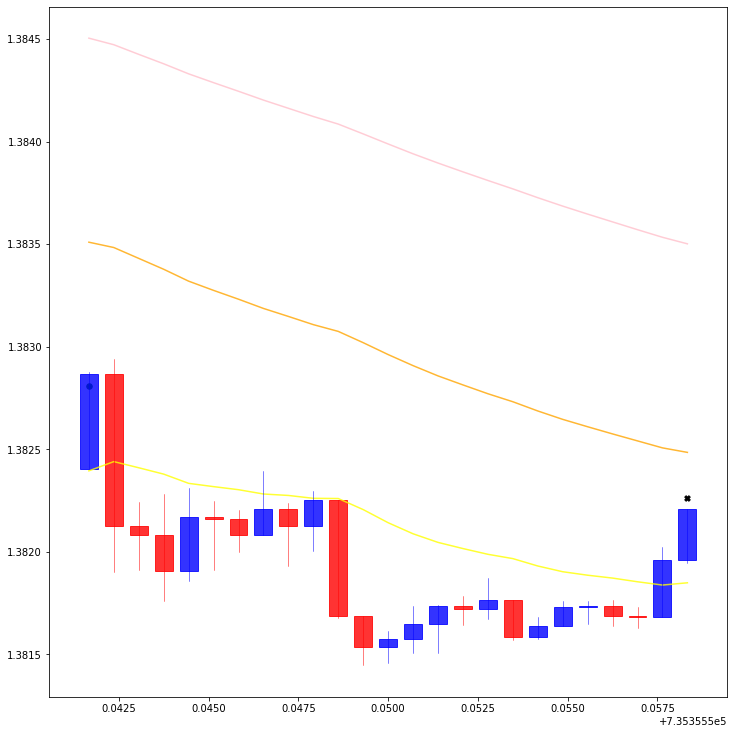

In [477]:
fig, ax = plt.subplots(figsize=(10, 10))

i = 0
x1 = data[~data['buy'].isna()].index[i]
x2 = data[~data['sell'].isna()].index[i]
ohlc = data.iloc[x1:x2+1]

# ohlc['ATR14'] = get_atr(ohlc)
ax.plot(ohlc['local time'], ohlc['ema1'], color='yellow', alpha=0.8)
ax.plot(ohlc['local time'], ohlc['ema2'], color='orange', alpha=0.8)
ax.plot(ohlc['local time'], ohlc['ema3'], color='pink', alpha=0.8)
ax.scatter(ohlc['local time'], ohlc['buy'], color='green', marker='o', s=30)
ax.scatter(ohlc['local time'], ohlc['sell'], color='black', marker='X', s=30)
# ax.scatter(ohlc['local time'], ohlc['up_fractal'], color='green', marker='^', s=30)
# ax.scatter(ohlc['local time'], ohlc['down_fractal'], color='red', marker='v', s=30)
candlestick_ohlc(ax, ohlc[['local time', 'open', 'high', 'low', 'close']].values, width=0.0005, colorup=COLORS[3],
                 colordown=COLORS[2], alpha=0.8)

# plt.axis('off')
fig.tight_layout(pad=0)

In [440]:
ohlc

,date,buy,open,high,low,close,ema1,ema2,ema3,stop,local time,up_fractal,down_fractal
91,2014-05-02 16:11:00,1.38631,1.386280,1.386415,1.386250,1.386255,1.386331,1.386305,1.385847,NaN,735355.674306,NaN,NaN
92,2014-05-02 16:12:00,NaN,1.386255,1.386375,1.386245,1.386255,1.386324,1.386303,1.385855,NaN,735355.675000,NaN,NaN
93,2014-05-02 16:13:00,NaN,1.386255,1.386385,1.386250,1.386380,1.386318,1.386301,1.385863,NaN,735355.675694,NaN,NaN
94,2014-05-02 16:14:00,NaN,1.386380,1.386385,1.386290,1.386295,1.386323,1.386304,1.385873,NaN,735355.676389,NaN,NaN
95,2014-05-02 16:15:00,NaN,1.386295,1.386355,1.386235,1.386250,1.386321,1.386304,1.385881,NaN,735355.677083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,2014-05-09 12:38:00,NaN,1.377745,1.378035,1.377745,1.377870,1.377646,1.378025,1.378647,NaN,735362.526389,NaN,NaN
811,2014-05-09 12:39:00,NaN,1.377870,1.378065,1.377865,1.378045,1.377667,1.378019,1.378631,NaN,735362.527083,NaN,NaN
812,2014-05-09 12:40:00,NaN,1.378045,1.378180,1.377955,1.378135,1.377703,1.378020,1.378620,NaN,735362.527778,NaN,NaN
813,2014-05-09 12:41:00,NaN,1.378135,1.378140,1.378035,1.378080,1.377744,1.378025,1.378610,NaN,735362.528472,1.37808,NaN


In [160]:
fig.savefig('fig.jpeg')